In [147]:
import numpy as np
from matplotlib import pyplot as plt

In [148]:
from agents import PowerSource, PowerLoad, PowerBus

Параметры графиков.

In [149]:
user_figsize = (12, 12)
user_fontsize = 14

In [150]:
Ubus_nom = 48.0

In [151]:
source_model = PowerSource(Rdroop=0.1, Uinit=Ubus_nom, beta=0.8)
load_model = PowerLoad(Unom=Ubus_nom, Pnom=100.0, Rline=0.05, beta=0.2)
bus_model = PowerBus(Uinit=Ubus_nom, beta=0.01)

In [152]:
i_load = 0.0
Ubus_init = 0.95*Ubus_nom
N_STEP = 100

source_current = np.zeros(N_STEP)
load_current = np.zeros(N_STEP)
bus_voltage = np.zeros(N_STEP)
for n in range(N_STEP):
    if n==0:
        source_current[n] = source_model.step(u=Ubus_init, Uref=Ubus_nom)
        load_current[n] = load_model.step(u=Ubus_init)
    else:
        source_current[n] = source_model.step(u=bus_voltage[n-1], Uref=Ubus_nom)
        load_current[n] = load_model.step(u=bus_voltage[n-1])
    bus_voltage[n] = bus_model.step(source_current[n] - load_current[n])

    if n==0:
        print(bus_voltage[n])
        print(source_current[n])
        print(load_current[n])

48.23605023819835
24.000000000000057
0.39497618016457336


In [153]:
print(bus_voltage)

[48.23605024 48.20510731 48.17455085 48.14488642 48.11646011 48.08949623
 48.06412692 48.04041527 48.01837344 47.99797662 47.9791739  47.96189663
 47.94606472 47.93159147 47.91838719 47.90636179 47.89542673 47.88549637
 47.87648885 47.86832672 47.86093721 47.85425242 47.8482093  47.84274958
 47.83781956 47.83336996 47.82935564 47.82573535 47.82247148 47.81952981
 47.81687919 47.81449138 47.81234075 47.8104041  47.8086604  47.80709066
 47.8056777  47.804406   47.80326156 47.80223172 47.80130509 47.80047139
 47.79972133 47.79904656 47.79843956 47.79789355 47.7974024  47.79696064
 47.7965633  47.79620592 47.7958845  47.79559543 47.79533545 47.79510163
 47.79489136 47.79470226 47.7945322  47.79437926 47.79424173 47.79411805
 47.79400683 47.79390681 47.79381687 47.79373599 47.79366326 47.79359786
 47.79353904 47.79348616 47.7934386  47.79339583 47.79335737 47.79332279
 47.7932917  47.79326373 47.79323859 47.79321598 47.79319565 47.79317736
 47.79316092 47.79314614 47.79313284 47.79312089 47

In [154]:
print(source_current)

[ 2.40000000e+01 -2.36050238e+00 -2.05107315e+00 -1.74550854e+00
 -1.44886422e+00 -1.16460108e+00 -8.94962291e-01 -6.41269155e-01
 -4.04152729e-01 -1.83734400e-01  2.02338386e-02  2.08260981e-01
  3.81033705e-01  5.39352828e-01  6.84085263e-01  8.16128097e-01
  9.36382124e-01  1.04573271e+00  1.14503635e+00  1.23511149e+00
  1.31673283e+00  1.39062792e+00  1.45747581e+00  1.51790698e+00
  1.57250424e+00  1.62180442e+00  1.66630042e+00  1.70644364e+00
  1.74264652e+00  1.77528516e+00  1.80470195e+00  1.83120812e+00
  1.85508622e+00  1.87659249e+00  1.89595904e+00  1.91339600e+00
  1.92909339e+00  1.94322300e+00  1.95593998e+00  1.96738442e+00
  1.97768276e+00  1.98694905e+00  1.99528613e+00  2.00278672e+00
  2.00953438e+00  2.01560438e+00  2.02106455e+00  2.02597596e+00
  2.03039361e+00  2.03436702e+00  2.03794076e+00  2.04115495e+00
  2.04404572e+00  2.04664554e+00  2.04898367e+00  2.05108641e+00
  2.05297744e+00  2.05467804e+00  2.05620738e+00  2.05758270e+00
  2.05881949e+00  2.05993

In [155]:
print(load_current)

[0.39497618 0.73378995 1.00457295 1.22093468 1.39376712 1.53178684
 1.64196907 1.72989511 1.80003055 1.85594799 1.90050527 1.93598822
 1.96422494 1.98667717 2.0045136  2.01866837 2.02988803 2.03876903
 2.04578782 2.05132483 2.05568375 2.05910687 2.06178746 2.0638796
 2.06550601 2.06676444 2.06773265 2.06847244 2.06903291 2.06945302
 2.06976363 2.06998915 2.07014889 2.07025805 2.07032861 2.07036995
 2.07038943 2.07039277 2.07038443 2.07036784 2.07034565 2.07031987
 2.07029203 2.07026326 2.0702344  2.07020605 2.07017864 2.07015246
 2.07012769 2.07010444 2.07008273 2.07006259 2.07004397 2.07002682
 2.07001108 2.06999666 2.06998349 2.06997148 2.06996055 2.06995061
 2.06994159 2.06993341 2.069926   2.06991929 2.06991322 2.06990774
 2.06990279 2.06989831 2.06989428 2.06989064 2.06988736 2.0698844
 2.06988173 2.06987933 2.06987716 2.06987521 2.06987346 2.06987188
 2.06987045 2.06986917 2.06986802 2.06986698 2.06986605 2.06986521
 2.06986445 2.06986377 2.06986316 2.06986261 2.06986212 2.069861

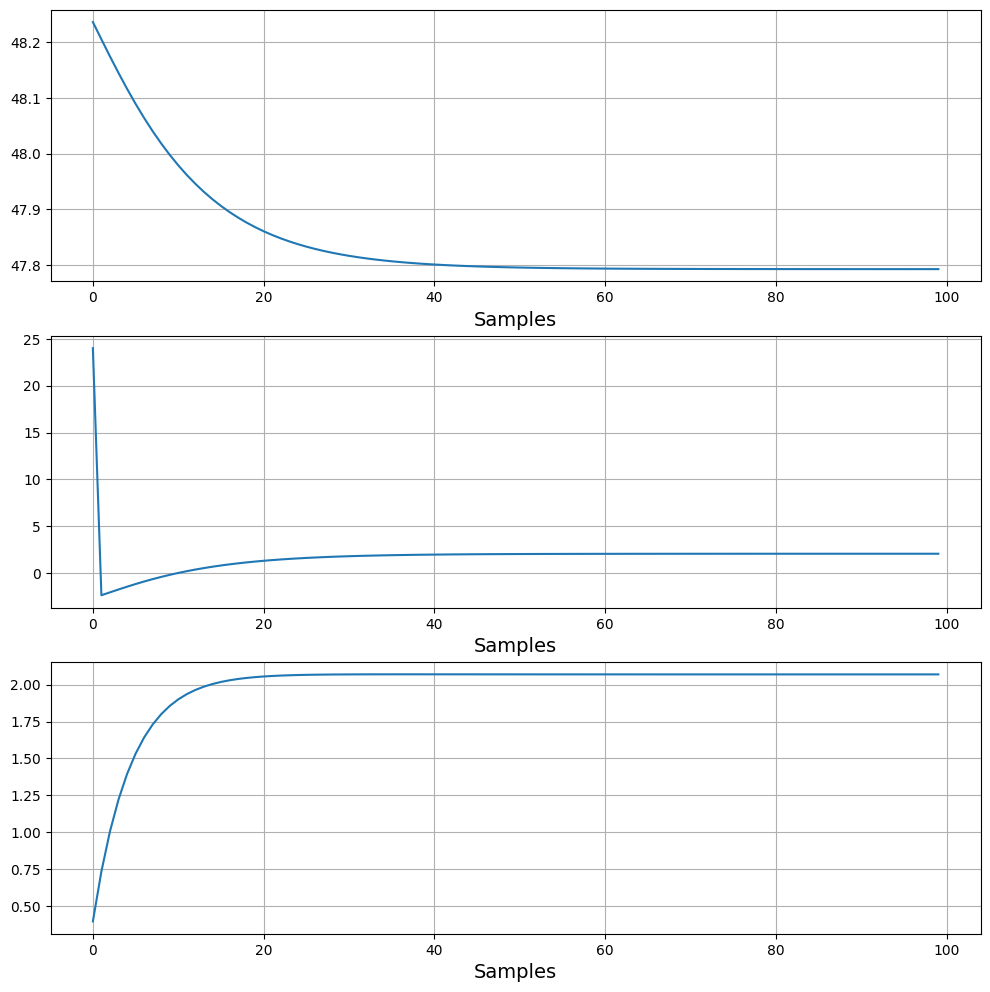

In [156]:
plot_vars = [bus_voltage, source_current, load_current]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=user_figsize)

for idx, ax in enumerate(axs):
    ax.plot(plot_vars[idx])
    ax.set_xlabel('Samples', fontsize=user_fontsize)
    #ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    #ax.legend()
plt.show()